In [1]:
import torch
import pandas as pd
import numpy as np
torch.manual_seed(42)
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
TRAIN_CSV = "hotel_booking_data_cleaned.csv"
train_df = pd.read_csv(TRAIN_CSV)

In [13]:
TARGET = "is_canceled"

# These columns are set AFTER cancellation happens — they leak the answer!
# reservation_status:      literally says "Canceled" / "Check-Out" / "No-Show"
# reservation_status_date: the date the status was recorded (only exists post-event)
LEAKAGE_COLS = ["reservation_status", "reservation_status_date"]

train_features = [
    x for x in train_df.columns
    if x != TARGET and x not in LEAKAGE_COLS
]

print("# of Training Features:", len(train_features))
print("Removed leakage columns:", LEAKAGE_COLS)
print()
print("Training Target Distribution:")
print(train_df[TARGET].value_counts().to_frame("count").assign(pct=lambda x: (x["count"] / x["count"].sum() * 100).round(2)))
print()

# of Training Features: 29
Removed leakage columns: ['reservation_status', 'reservation_status_date']

Training Target Distribution:
             count    pct
is_canceled              
0            75166  62.96
1            44224  37.04



In [12]:
print("All columns in train_features:")
for col in sorted(train_features):
    print(" ", col)

All columns in train_features:
  adr
  adults
  agent
  arrival_date_day_of_month
  arrival_date_month
  arrival_date_week_number
  arrival_date_year
  assigned_room_type
  babies
  booking_changes
  children
  company
  country
  customer_type
  days_in_waiting_list
  deposit_type
  distribution_channel
  hotel
  is_repeated_guest
  lead_time
  market_segment
  meal
  previous_bookings_not_canceled
  previous_cancellations
  required_car_parking_spaces
  reservation_status
  reservation_status_date
  reserved_room_type
  stays_in_week_nights
  stays_in_weekend_nights
  total_of_special_requests


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# One-hot encode categorical columns
X_df = pd.get_dummies(train_df[train_features], drop_first=False)

# Fill any missing values with the median of each column
# Why median? It's a safe middle value and not affected by extreme outliers
X_df = X_df.fillna(X_df.median(numeric_only=True))

X_train = torch.tensor(X_df.to_numpy(dtype=np.float32), device=device)
y_train = torch.tensor(train_df[TARGET].to_numpy(dtype=np.float32), device=device).view(-1, 1)

print('Device:', device)
print('X shape:', X_train.shape)
print('y shape:', y_train.shape)
print('NaN in X_train:', torch.isnan(X_train).any().item())  # should be False now

Device: cuda
X shape: torch.Size([119390, 257])
y shape: torch.Size([119390, 1])
NaN in X_train: False


In [15]:
# Split data into training and validation sets
# We keep 80% for training and hold out 20% to check real performance
from sklearn.model_selection import train_test_split

# Split indices (we split the numpy arrays, then convert to tensors)
X_np = X_df.to_numpy(dtype="float32")
y_np = train_df[TARGET].to_numpy(dtype="float32")

X_tr, X_val, y_tr, y_val = train_test_split(
    X_np, y_np,
    test_size=0.2,       # 20% goes to validation
    random_state=42,     # fixed seed so results are reproducible
    stratify=y_np        # keep same class ratio in both splits
)

# Convert to PyTorch tensors on device
X_train = torch.tensor(X_tr, device=device)
y_train = torch.tensor(y_tr, device=device).view(-1, 1)
X_val   = torch.tensor(X_val, device=device)
y_val   = torch.tensor(y_val, device=device).view(-1, 1)

print(f"Train size: {X_train.shape[0]} rows")
print(f"Val   size: {X_val.shape[0]} rows")

Train size: 95512 rows
Val   size: 23878 rows


In [16]:
batch_size = 32

# Training loader — shuffled because order shouldn't matter during training
train_dataset = TensorDataset(X_train, y_train)
train_loader  = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation loader — NOT shuffled, we just want to measure performance
val_dataset = TensorDataset(X_val, y_val)
val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val   batches: {len(val_loader)}")

Train batches: 2985
Val   batches: 747


In [17]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1   = nn.Linear(input_size, hidden_size)
        self.fc2   = nn.Linear(hidden_size, hidden_size)
        self.fc3   = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) 
        
        return x
        
input_features = X_train.shape[1]
hidden_neurons = 360
output_classes = 1

model = SimpleMLP(input_size=input_features, hidden_size=hidden_neurons, output_size=output_classes).to(device)

from custom_torchinfo import custom_summary
custom_summary(model, input_size=(32, input_features))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleMLP                                [32, 257]                 [32, 1]                   --                        True
├─Linear: 1-1                            [32, 257]                 [32, 360]                 92,880                    True
├─ReLU: 1-2                              [32, 360]                 [32, 360]                 --                        --
├─Linear: 1-3                            [32, 360]                 [32, 360]                 129,960                   True
├─ReLU: 1-4                              [32, 360]                 [32, 360]                 --                        --
├─Linear: 1-5                            [32, 360]                 [32, 1]                   361                       True
Total params: 223,201
Trainable params: 223,201
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.14
Input size (MB): 0.

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
SimpleMLP                                [32, 257]                 [32, 1]                   --                        True
├─Linear: 1-1                            [32, 257]                 [32, 360]                 92,880                    True
├─ReLU: 1-2                              [32, 360]                 [32, 360]                 --                        --
├─Linear: 1-3                            [32, 360]                 [32, 360]                 129,960                   True
├─ReLU: 1-4                              [32, 360]                 [32, 360]                 --                        --
├─Linear: 1-5                            [32, 360]                 [32, 1]                   361                       True
Total params: 223,201
Trainable params: 223,201
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.14
Input size (MB): 0.

In [18]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
# Diagnostics — check for NaN/Inf in inputs
print("NaN in X_train:", torch.isnan(X_train).any().item())
print("Inf in X_train:", torch.isinf(X_train).any().item())
print("NaN in y_train:", torch.isnan(y_train).any().item())

# Check what one forward pass produces
model.eval()
with torch.no_grad():
    sample = X_train[:32]
    out = model(sample)
    print("Sample logits min/max:", out.min().item(), out.max().item())
    print("NaN in logits:", torch.isnan(out).any().item())
model.train()

NaN in X_train: True
Inf in X_train: False
NaN in y_train: False
Sample logits min/max: nan nan
NaN in logits: True


SimpleMLP(
  (fc1): Linear(in_features=1186, out_features=360, bias=True)
  (fc2): Linear(in_features=360, out_features=360, bias=True)
  (fc3): Linear(in_features=360, out_features=1, bias=True)
  (relu): ReLU()
)

In [19]:
num_epochs = 10

for epoch in range(num_epochs):

    # ── TRAINING PHASE ──────────────────────────────────────────────
    model.train()   # tells the model "we are training now"
    epoch_loss = 0.0
    correct, total, num_batches = 0, 0, 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()          # 1. clear old gradients
        logits = model(batch_X)        # 2. forward pass
        loss   = loss_fn(logits, batch_y)  # 3. compute loss
        loss.backward()                # 4. compute gradients
        optimizer.step()               # 5. update weights

        epoch_loss  += loss.item()
        num_batches += 1
        probs  = torch.sigmoid(logits)
        preds  = (probs >= 0.5).float()
        correct += (preds == batch_y).sum().item()
        total   += batch_y.size(0)

    train_loss = epoch_loss / num_batches
    train_acc  = correct / total

    # ── VALIDATION PHASE ────────────────────────────────────────────
    model.eval()    # tells the model "we are evaluating now — no learning"
    val_loss_sum = 0.0
    val_correct, val_total, val_batches = 0, 0, 0

    with torch.no_grad():   # no_grad = don't compute gradients (saves memory)
        for batch_X, batch_y in val_loader:
            logits = model(batch_X)
            loss   = loss_fn(logits, batch_y)
            val_loss_sum += loss.item()
            val_batches  += 1
            probs  = torch.sigmoid(logits)
            preds  = (probs >= 0.5).float()
            val_correct += (preds == batch_y).sum().item()
            val_total   += batch_y.size(0)

    val_loss = val_loss_sum / val_batches
    val_acc  = val_correct / val_total

    print(f"Epoch [{epoch+1:>2}/{num_epochs}]  "
          f"Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  |  "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_acc:.4f}")

Epoch [ 1/10]  Train Loss: 0.5755  Train Acc: 0.7072  |  Val Loss: 0.4538  Val Acc: 0.7849
Epoch [ 2/10]  Train Loss: 0.4551  Train Acc: 0.7840  |  Val Loss: 0.5760  Val Acc: 0.6904
Epoch [ 3/10]  Train Loss: 0.4261  Train Acc: 0.7985  |  Val Loss: 0.6345  Val Acc: 0.7576
Epoch [ 4/10]  Train Loss: 0.4107  Train Acc: 0.8060  |  Val Loss: 0.4248  Val Acc: 0.7995
Epoch [ 5/10]  Train Loss: 0.4003  Train Acc: 0.8113  |  Val Loss: 0.3895  Val Acc: 0.8129
Epoch [ 6/10]  Train Loss: 0.3995  Train Acc: 0.8116  |  Val Loss: 0.3864  Val Acc: 0.8110
Epoch [ 7/10]  Train Loss: 0.3881  Train Acc: 0.8144  |  Val Loss: 0.4253  Val Acc: 0.7955
Epoch [ 8/10]  Train Loss: 0.3873  Train Acc: 0.8157  |  Val Loss: 0.3681  Val Acc: 0.8235
Epoch [ 9/10]  Train Loss: 0.3814  Train Acc: 0.8191  |  Val Loss: 0.3710  Val Acc: 0.8288
Epoch [10/10]  Train Loss: 0.3753  Train Acc: 0.8222  |  Val Loss: 0.3624  Val Acc: 0.8277


Classification Report (Validation Set):
              precision    recall  f1-score   support

Not Canceled       0.82      0.93      0.87     15033
    Canceled       0.85      0.65      0.74      8845

    accuracy                           0.83     23878
   macro avg       0.83      0.79      0.80     23878
weighted avg       0.83      0.83      0.82     23878



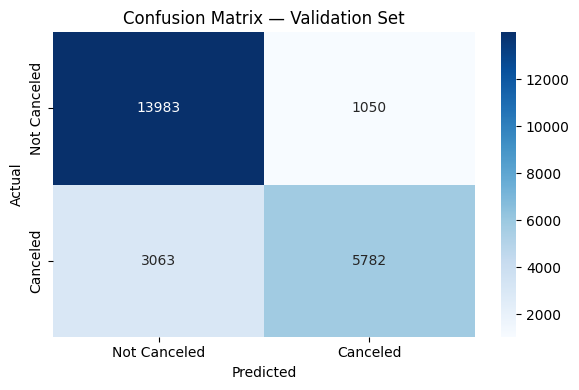

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ── Collect ALL validation predictions ──────────────────────────────
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        logits = model(batch_X)
        probs  = torch.sigmoid(logits)
        preds  = (probs >= 0.5).float()
        all_preds.append(preds.cpu())
        all_labels.append(batch_y.cpu())

# Stack all batches into single tensors then convert to numpy
all_preds  = torch.cat(all_preds).numpy().astype(int).flatten()
all_labels = torch.cat(all_labels).numpy().astype(int).flatten()

# ── Classification Report ────────────────────────────────────────────
# Precision: of all bookings predicted as canceled, how many really were?
# Recall:    of all bookings that were canceled, how many did we catch?
# F1:        harmonic mean of precision and recall (best balance metric)
print("Classification Report (Validation Set):")
print(classification_report(all_labels, all_preds, target_names=["Not Canceled", "Canceled"]))

# ── Confusion Matrix ─────────────────────────────────────────────────
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Canceled", "Canceled"],
            yticklabels=["Not Canceled", "Canceled"])
plt.title("Confusion Matrix — Validation Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()